## 1. Dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # Plotting library
import numpy as np # Algebra library
import tensorflow as tf # Tensorflow
import os # Folder management library
import pandas as pd # Essentially puts data in spreadsheeet
from astropy.io import fits # Reading .fits files
#from PIL import Image # Image processing library
import scipy.misc # General stats functions
import random # Pseudo random number generator
from sklearn.model_selection import train_test_split # To split data into train, test, validation
import pickle # Serializing module.
from matplotlib.image import imread # Plotting images

### Available CPUs and GPUs on Machine
Just shows what devices are available.

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8218000574718395919
]


### Reset Graph
Reset Tensorflow state.

In [3]:
tf.reset_default_graph()

### Set Seed for Reproducibility (Optional)

In [4]:
np.random.seed(42)
tf.set_random_seed(42)

## 2. Load Data for Training, Validation, and Testing 
Run this cell if you will be training the architecture.

In [5]:
# Read data from disk. X contains images, and y contains labels.
X_unpickle = open('X_new.pickle', 'rb')
y_unpickle = open('y_new.pickle', 'rb')

# load the unpickle object into a variable
X = pickle.load(X_unpickle)
y = pickle.load(y_unpickle)

# Split data into train, validation, test
# Stratify with respect to y so that there is an even number of 1s and 0s in each set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50/350, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=50/300, random_state=42, stratify=y_train)
# Convert lists to numpy arrays
X_train, X_test, X_val = np.array(X_train), np.array(X_test), np.array(X_val)
y_train, y_test, y_val = np.array(y_train), np.array(y_test), np.array(y_val)

print('Training Set (No. imgs, length, width) and Labels (No. imgs):', X_train.shape, y_train.shape)
print('Validation Set (No. imgs, length, width) and Labels (No. imgs):', X_val.shape, y_val.shape)
print('Test Set (No. imgs, length, width) and Labels (No. imgs):', X_test.shape, y_test.shape)

Training Set (No. imgs, length, width) and Labels (No. imgs): (250, 200, 200) (250,)
Validation Set (No. imgs, length, width) and Labels (No. imgs): (50, 200, 200) (50,)
Test Set (No. imgs, length, width) and Labels (No. imgs): (50, 200, 200) (50,)


### Visualize Data

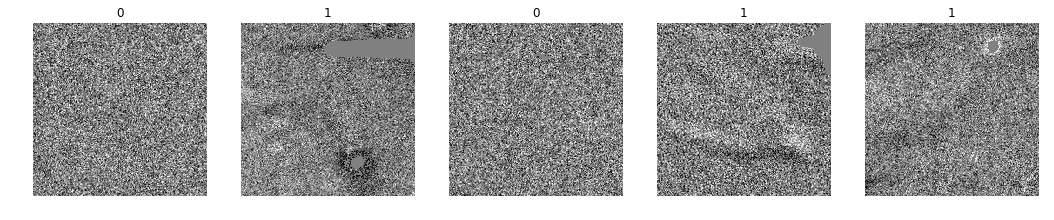

In [6]:
plt.figure(figsize=(18, 11))
for i in range(1, 6):
    plt.subplot(1, 5, i)
    sample_image = X_train[i]
    plt.imshow(sample_image, cmap='gray')
    plt.title(y_train[i])
    plt.axis("off")
plt.show()

## 3. Define Model Architecture

### Functions

In [7]:
def predictions(caps_Lminus1, dims_Lminus1, output_Lminus1, 
                caps_L, dims_L, batch_size, weight_sharing=False, grid_cells_Lminus1=1, name=None):
    
    with tf.name_scope(name, default_name="predictions"):
        if weight_sharing == False:
            output_Lminus1 = tf.squeeze(output_Lminus1, axis=[1, 4], name="output_Lminus1")

        # Initialize first array to random normal
        init_sigma = 0.1
        W_init = tf.random_normal(shape=(1, caps_Lminus1, caps_L, dims_L, dims_Lminus1),
                                  stddev=init_sigma, dtype=tf.float32, name="W_init")
        W = tf.Variable(W_init, name="W")
        tf.summary.histogram("W", W)
        
        # Tile W for the batch
        W_tiled = tf.tile(W, [batch_size, grid_cells_Lminus1, 1, 1, 1], name="W_tiled") 
        # the 1 in the shape argument in tf.tile means keep dimension from W.


        # -1 means add another dimension to the end of tensor
        output_expanded_Lminus1 = tf.expand_dims(output_Lminus1, -1, name="output_expanded_Lminus1")
        # 2 means add another dimension to the 2th position of tensor
        output_tile_Lminus1 = tf.expand_dims(output_expanded_Lminus1, 2, name="output_tile_Lminus1")
        # 1 in shape argument means keep dimensions from caps1_output_tile
        output_tiled_Lminus1 = tf.tile(output_tile_Lminus1, [1, 1, caps_L, 1, 1], name="output_tiled_Lminus1")
        # Get prediction tensor (3rd array) by using t.matmul
        predicted_L = tf.matmul(W_tiled, output_tiled_Lminus1, name="predicted_L")
    
        return predicted_L

    
def routing(caps_Lminus1, caps_L, batch_size, iterations, predicted_L, name=None):
    
    with tf.name_scope(name, default_name="routing"):
        # initialize the raw routing weights to zero
        # The two extra 1s is so that raw_weights and weighted_predictions have the same size
        raw_weights = tf.zeros([batch_size, caps_Lminus1, caps_L, 1, 1], dtype=np.float32, name="raw_weights")

        for r in range(0, iterations):

            # c_i = softmax(b_i)
            routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")
            # weighted sum of all the predicted output vectors for each second-layer capsule
            weighted_predictions = tf.multiply(routing_weights, predicted_L, name="weighted_predictions")
            weighted_sum = tf.reduce_sum(weighted_predictions, axis=(1), keepdims=True, name="weighted_sum")

            # Squash weighted_sum (s_j) to get output for 2nd capsules (v_j)
            output_L = squash(weighted_sum, axis=-2, name="output_L")

            # Make caps2_output same size as predicted_caps
            output_tiled_L = tf.tile(output_L, 
                                         [1, caps_Lminus1, 1, 1, 1], 
                                         name="output_tiled_L")
            # the 1 in the shape argument in tf.tile means keep dimension from caps2_output.

            # Dot Product
            agreement = tf.matmul(predicted_L, output_tiled_L, transpose_a=True, name="agreement")
            # Update raw_weights
            raw_weights = tf.add(raw_weights, agreement, name="raw_weights")

        return output_L, routing_weights
        
# safe_norm taken from Aurélien Geron
def squash(s, axis=-1, epsilon=1e-7, name=None):
    
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector
    
    
# safe_norm taken from Aurélien Geron
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

### Input 

In [8]:
# Placeholder for the input images (batch size, length, width, greyscale).
# Batch size, length, and width are set to None as they can vary. 
X = tf.placeholder(shape=[None, None, None, 1], dtype=tf.float32, name="X")
tf.summary.image('X', X)
y = tf.placeholder(shape=[None], dtype=tf.float32, name="y")

### Convolutional Layer
Used to get feature map.

In [9]:
# Hyper-parameters
conv1_params = {
    "filters": 16,
    "kernel_size": 9,
    "strides": 3,
    "padding": "valid",
    "activation": tf.nn.relu,
}
# Convolve image with conv1 filters
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
tf.summary.histogram("conv1", conv1)

<tf.Tensor 'conv1_1:0' shape=() dtype=string>

### ConvCaps Layer
Also known as primary capsule layer.

In [10]:
# No. of dimenions a single capsule contains.
convcaps_dims = 8 
# No. of capsules per grid cell.
convcaps_caps_types = 32 

convcaps_params = {
    "filters": convcaps_caps_types * convcaps_dims,
    "kernel_size": 5,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu 
}
# Convolve conv1 with filters.
convcaps = tf.layers.conv2d(conv1, name="convcaps", **convcaps_params)
tf.summary.histogram("convcaps", convcaps)

# Length and width of convaps layer.
convcaps_grid_length = tf.shape(convcaps)[1]   
convcaps_grid_width = tf.shape(convcaps)[2] 
convcaps_grid_cells = convcaps_grid_length * convcaps_grid_width
# Total No. capsules in convcaps layer.
convcaps_caps = convcaps_caps_types * convcaps_grid_cells

# Reshape convcaps so that it is easier to work with.
convcaps_reshape = tf.reshape(convcaps, [-1, convcaps_caps, convcaps_dims], name="convcaps_reshape")
# Squash convcaps with squashing function.
convcaps_output = squash(convcaps_reshape, name="convcaps_output")

### First Capsule Layer
The first capsule layer that is generated by the routing algorithm.

In [11]:
# The batch size
batch_size = tf.shape(X)[0]

caps1_caps = 24
caps1_dims = 12

caps1_predictions = predictions(convcaps_caps_types, convcaps_dims, convcaps_output, 
                                caps1_caps, caps1_dims, batch_size, True, convcaps_grid_cells, "caps1_predictions")

caps1_output, routing1 = routing(convcaps_caps, caps1_caps, 
                                  batch_size, 9, caps1_predictions, "routing1")

Instructions for updating:
dim is deprecated, use axis instead


### Second Capsule Layer

In [12]:
caps2_caps = 8
caps2_dims = 16

caps2_predictions = predictions(caps1_caps, caps1_dims, caps1_output, 
                                caps2_caps, caps2_dims, batch_size, False, 1, "caps2_predictions")

caps2_output, routing2 = routing(caps1_caps, caps2_caps, batch_size, 9, caps2_predictions, "routing2")

### Third Capsule Layer

In [13]:
caps3_caps = 1
caps3_dims = 16

caps3_predictions = predictions(caps2_caps, caps2_dims, caps2_output, 
                                caps3_caps, caps3_dims, batch_size, False, 1, "caps3_predictions")


caps3_output, routing3 = routing(caps2_caps, caps3_caps, batch_size, 9, caps3_predictions, "routing3")

### Calculate Accuracy
Accuracy given by $$ \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Dataset Size}}$$

In [14]:
with tf.name_scope(name="accuracy_cell"):
    
    # Lengths of capsules represent probability that entity exists.
    lengths = safe_norm(caps3_output, axis=-2, name="lengths")
    # Round lengths to determine predicted class.
    lengths_rounded = tf.round(lengths, name="lengths_rounded")
    # Remove dimensions of size 1 from lengths_rounded
    y_predictions = tf.squeeze(lengths_rounded, axis=[1,2,3], name="y_predictions")
    
    # If y matches y_predictions than 1 otherwise 0.
    correct = tf.equal(y, y_predictions, name="correct")
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    tf.summary.scalar('accuracy', accuracy)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Calculate Loss

In [15]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5


with tf.name_scope(name="loss_cell"):

    T = tf.reshape(y, shape=[-1, 1], name="T")
    # Compute norm of each capsule in digitcaps
    caps3_output_norm = safe_norm(caps3_output, axis=-2, keep_dims=True, name="caps3_output_norm")
    
    present_error_raw = tf.square(tf.maximum(0., m_plus - caps3_output_norm), name="present_error_raw")
    present_error = tf.reshape(present_error_raw, shape=(-1, caps3_caps), name="present_error")
    # -1 tells reshape to calculate the size of this dimension. 

    absent_error_raw = tf.square(tf.maximum(0., caps3_output_norm - m_minus), name="absent_error_raw")
    absent_error = tf.reshape(absent_error_raw, shape=(-1, caps3_caps), name="absent_error")
    # -1 tells reshape to calculate the size of this dimension. 

    # Compute Margin Loss
    L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error, name="L")
    loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="loss")
    tf.summary.scalar('loss', loss)

### Adam Optimizer
Initialize adam optimizer to minimize $\texttt{loss}$.

In [16]:
with tf.name_scope(name="train"):
    learning_rate = tf.placeholder(tf.float32, shape=[])
    tf.summary.scalar('learning_rate', learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss, name="training_op")
    
merged_summary = tf.summary.merge_all()
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## 4. Train the Architecture
Run the below cell if you would like to train the architecture.

### Load Learning Rate

In [17]:
# Initial Learning Rate.
learning_r = 0.00000001
# Batch size for training.
batch_size = 5

# Save model and tensorboard data to this folder
folder = '../model'

# Load time step for Tensorboard.
if os.path.isfile(folder+'/time_step.pickle'):
    time_step_unpickle = open(folder+'/time_step.pickle', 'rb')
    time_step = pickle.load(time_step_unpickle)
else:
    time_step = 0
    
# Load learning rate    
if os.path.isfile(folder+'/learning_r.pickle'):
    learning_r_unpickle = open(folder+'/learning_r.pickle', 'rb')
    learning_r = pickle.load(learning_r_unpickle)
            
print('time step: ', time_step)
print('learning rate: ', learning_r)

time step:  0
learning rate:  1e-08


### Training

In [19]:
n_epochs = 10000
restore_checkpoint = True

n_iterations_per_epoch = len(X_train) // batch_size
n_iterations_validation = len(X_val) // batch_size
best_loss_val = np.infty

if not os.path.exists(folder):
    os.makedirs(folder)
checkpoint_path = folder+"/my_capsule_network"


with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    writer = tf.summary.FileWriter(folder+"/tensorboard/")
    writer.add_graph(sess.graph, global_step=time_step)

    lr_count = 0
    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch = X_train[(batch_size*(iteration-1)):(batch_size*iteration)]
            y_batch = y_train[(batch_size*(iteration-1)):(batch_size*iteration)]
            
            # Every 5 iterations display loss
            if time_step % 5 == 0:
                loss_, merged_summary_, y_predictions_, y_ = sess.run(
                    [loss, merged_summary, y_predictions, y],
                    feed_dict={X: X_batch.reshape([-1, 200, 200, 1]),
                               y: y_batch, 
                               learning_rate: learning_r})
                writer.add_summary(merged_summary_, time_step)
                print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.6f}  Prediction: {}  y: {}".format(
                    iteration, n_iterations_per_epoch, iteration * 100 / n_iterations_per_epoch,
                    loss_, y_predictions_, y_), end="")
            
            # Train Model
            _ = sess.run([training_op], feed_dict={X: X_batch.reshape([-1, 200, 200, 1]),
                                                   y: y_batch, 
                                                   learning_rate: learning_r})
            
            time_step = time_step + 1
            
        # At the end of each epoch measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            
            X_batch = X_val[(batch_size*(iteration-1)):(batch_size*iteration)]
            y_batch = y_val[(batch_size*(iteration-1)):(batch_size*iteration)]
            
            loss_val, acc_val = sess.run([loss, accuracy],
                                         feed_dict={X: X_batch.reshape([-1, 200, 200, 1]),
                                                    y: y_batch})
            
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(iteration, n_iterations_validation,
                                                                   iteration * 100 / n_iterations_validation),
                  end=" " * 10)
            
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))
        
        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val
        else:
            lr_count = lr_count + 1
            
            # If validation loss has not decreased for 3 epochs than decrease learning rate by factor of 10.
            if lr_count == 10:
                learning_r = learning_r/10
                lr_count = 0
                print('Learning rate has decreased to:', learning_r)
            
                # Save learning rate.
                with open(folder+'/learning_r.pickle', 'wb') as f:
                    pickle.dump(learning_r, f, protocol=pickle.HIGHEST_PROTOCOL)
                    
                if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
                    saver.restore(sess, checkpoint_path)
                    
        # Save time step.
        with open(folder+'/time_step.pickle', 'wb') as f:
            pickle.dump(time_step, f, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Restoring parameters from ../model/my_capsule_network
Iteration: 1/50 (2.0%)  Loss: 0.088118  Prediction: [1. 0. 0. 0. 1.]  y: [0. 0. 1. 0. 1.]

KeyboardInterrupt: 

### Evaluate on Test Set

In [20]:
n_iterations_test = len(X_test) // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = X_test[(batch_size*(iteration-1)):(batch_size*iteration)], y_test[(batch_size*(iteration-1)):(batch_size*iteration)]
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 200, 200, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))
    


INFO:tensorflow:Restoring parameters from ../model/my_capsule_network
Evaluating the model: 1/10 (10.0%)          

KeyboardInterrupt: 

### Total Number of Trainable Weights in Model

In [21]:
np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])

216608